In [36]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from psql_methods import execute_commands
from Openseas_Methods import *
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
from pymongo import MongoClient
from tqdm import tqdm
from datetime import datetime
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
import os
import pandas as pd
from image_utils import pull_image_from_url
import multiprocessing
plt.style.use('https://raw.githubusercontent.com/gregdeon/plots/main/style.mplstyle')
plt.matplotlib.rcParams['figure.dpi'] = 300
plt.matplotlib.rcParams['font.size'] = 6
skip_list=['ens','base-introduced','fundrop-pass','gemesis','apecoin','dai-stablecoin','uniswap','1inch-token']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
command = ["SELECT slug FROM nfttoimage GROUP BY slug HAVING COUNT(*) >= 5000 and COunt(*)<15000 ORDER BY random() LIMIT 10"]
rows  = execute_commands(command)
rows = tuple([x[0] for x in rows])
rows

('the-wolfis-v2',
 '888innercirclethedrops',
 'justafishgenesis',
 'therealkingship',
 'larva-lads',
 'the-sevens-genesis',
 'cosmicduckstofuse',
 'rawrtownwtf',
 'marimo-life',
 'niftyriots')

In [80]:
command = [f"select * from nfttoimage where slug in {rows}"]
rows  = execute_commands(command)

In [81]:
# Column names for the DataFrame
columns = ['slug', 'token_id', 'url']

# Create a DataFrame from the list of tuples
df = pd.DataFrame(rows, columns=columns)
grouped_data = df.groupby('slug').apply(lambda x: (x['slug'].iloc[0], list(zip(x['token_id'], x['url']))))
args = list(grouped_data)


In [82]:
records = []
num_processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=num_processes) as pool: # Use all cores   
    for result in pool.starmap(pull_image_from_url, args):
        records.append(result)

/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# After previous step run feature_extract on newly generated images

In [2]:
#We assume the features have already been computed by the feature_extract_notebook
# model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
import feature_extract
import torch
model_string = 'dinov2_vits14'

data_path = '/global/scratch/tlundy/NFT_Research/nft_research/Dino/embedding_test'
out_path = f'/global/scratch/tlundy/NFT_Research/nft_research/Dino/embedding_test_features/{model_string}'
feature_path = out_path+'/testfeat.pth'
features = torch.load(feature_path)
labels = feature_extract.get_labels(data_path)
file_names = feature_extract.get_filenames(data_path)
print(file_names[0])
print(labels)

Dataset ReturnIndexDataset
    Number of datapoints: 71792
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/embedding_test/val
('888innercirclethedrops', '0')
tensor([0, 0, 0,  ..., 9, 9, 9])


In [3]:
features_list = features.tolist()

# Create a pandas DataFrame
data = {'Label': labels.tolist(), 'Features': features_list,'Collection':[x[0] for x in file_names],
        'NFT_num':[x[1] for x in file_names]}
df_og = pd.DataFrame(data)

In [4]:
del features
del features_list

In [8]:
def normalize_vector(vector):
    magnitude = np.linalg.norm(vector)
    if magnitude != 0:
        return vector / magnitude
    else:
        return vector
df_og['norm_features'] = df_og['Features'].apply(normalize_vector)

In [16]:
df_og['Collection'].value_counts()
df_2

,True Dists,5000,2500,500,250,50,25,10,5
0,0.581071,0.003463,0.007466,0.011643,0.011666,0.039766,0.036550,0.069230,0.141940
1,0.581071,0.001191,0.003766,0.014544,0.007525,0.015991,0.040358,0.085655,0.125874
2,0.581071,0.005702,0.002582,0.004465,0.017973,0.119141,0.052665,0.146174,0.224481
3,0.581071,0.001673,0.006174,0.017303,0.023342,0.012447,0.054655,0.077761,0.036103
4,0.581071,0.003325,0.004848,0.028475,0.040597,0.029696,0.061216,0.084752,0.025227
5,0.581071,0.004103,0.005258,0.005085,0.022059,0.029931,0.164655,0.113494,0.148398
6,0.581071,0.001734,0.010964,0.009661,0.027861,0.077277,0.051255,0.150669,0.112255
7,0.581071,0.006874,0.002585,0.020984,0.014381,0.049371,0.074771,0.160230,0.119462
8,0.581071,0.004945,0.006181,0.006240,0.030398,0.095600,0.099498,0.007992,0.140545
9,0.581071,0.005719,0.005668,0.022330,0.016199,0.052191,0.050173,0.095827,0.134282


In [43]:
import numpy as np
from scipy.stats import pearsonr
# Group the DataFrame by 'Label'
grouped = df_og.groupby('Label')
slug_dfs = []
for label,df in grouped:
    # Compute average feature vector for each label
    column = 'norm_features'
    true_vec = np.mean(df[column].tolist(), axis=0)
    true_dists = [np.linalg.norm(true_vec - np.array(row[column])) for _, row in df.iterrows()]
    avg_true_dists = sum(true_dists)/len(true_dists)
    num_samples = 50
    sizes = [5000,2500,500,250,100,50,25,10,5]
    afvs = []
    for x in tqdm(range(0,num_samples)):
        samples = []
        samples.append(avg_true_dists)
        for size in sizes:
            sampled_rows = df.sample(size,replace=True)   
            # Compute average feature vector for the current label
            avg_feature_vector = np.mean(sampled_rows[column].tolist(), axis=0)
            dist = [np.linalg.norm(avg_feature_vector - np.array(row[column])) for _, row in df.iterrows()]
            gaps = [abs(x-y) for x, y in zip(true_dists, dist)]
            avg_dist = sum(gaps)/len(gaps)
            samples.append(avg_dist)
        afvs.append(samples)
    df_2 = pd.DataFrame(afvs,columns=['True Dists']+sizes)
    slug_dfs.append((label,df_2))
    print(label)
    print(df_2.describe())
# print(average_feature_vectors)

100%|█████████████████████████████████████████████| 50/50 [03:09<00:00,  3.80s/it]


0
         True Dists       5000       2500        500        250        100  \
count  5.000000e+01  50.000000  50.000000  50.000000  50.000000  50.000000   
mean   2.237451e-01   0.001372   0.002195   0.004378   0.006637   0.010306   
std    2.803737e-17   0.000711   0.000969   0.002155   0.003000   0.003820   
min    2.237451e-01   0.000298   0.000724   0.001477   0.001257   0.000945   
25%    2.237451e-01   0.000866   0.001492   0.002925   0.004235   0.007350   
50%    2.237451e-01   0.001190   0.002082   0.003693   0.006544   0.010898   
75%    2.237451e-01   0.001778   0.002721   0.005447   0.008777   0.013262   
max    2.237451e-01   0.003328   0.004300   0.011018   0.012445   0.018511   

              50         25         10          5  
count  50.000000  50.000000  50.000000  50.000000  
mean    0.015284   0.019518   0.033078   0.047207  
std     0.007259   0.009560   0.016791   0.024736  
min     0.004175   0.005665   0.007114   0.007820  
25%     0.009158   0.012691   0.019

100%|█████████████████████████████████████████████| 50/50 [04:22<00:00,  5.25s/it]


1
       True Dists       5000       2500        500        250        100  \
count   50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean     0.477893   0.001105   0.001464   0.003462   0.005022   0.007278   
std      0.000000   0.000314   0.000440   0.001148   0.001412   0.002165   
min      0.477893   0.000583   0.000712   0.001665   0.002683   0.003702   
25%      0.477893   0.000886   0.001236   0.002747   0.003913   0.005981   
50%      0.477893   0.001035   0.001363   0.003179   0.004791   0.006924   
75%      0.477893   0.001310   0.001579   0.004046   0.006047   0.008306   
max      0.477893   0.001901   0.003006   0.007874   0.009110   0.016422   

              50         25         10          5  
count  50.000000  50.000000  50.000000  50.000000  
mean    0.011321   0.018070   0.031160   0.059015  
std     0.003185   0.005342   0.008430   0.019880  
min     0.006526   0.009967   0.019437   0.032629  
25%     0.009155   0.014596   0.024617   0.046008  
5

100%|█████████████████████████████████████████████| 50/50 [03:29<00:00,  4.20s/it]


2
         True Dists       5000       2500        500        250        100  \
count  5.000000e+01  50.000000  50.000000  50.000000  50.000000  50.000000   
mean   5.224673e-01   0.001159   0.001572   0.003656   0.005260   0.008238   
std    1.121495e-16   0.000281   0.000420   0.001163   0.001489   0.002041   
min    5.224673e-01   0.000620   0.000802   0.001727   0.002946   0.004000   
25%    5.224673e-01   0.001010   0.001315   0.002989   0.004141   0.006796   
50%    5.224673e-01   0.001121   0.001542   0.003469   0.004991   0.007821   
75%    5.224673e-01   0.001271   0.001760   0.003995   0.006458   0.009336   
max    5.224673e-01   0.001839   0.002724   0.007142   0.008391   0.014674   

              50         25         10          5  
count  50.000000  50.000000  50.000000  50.000000  
mean    0.013010   0.017476   0.033541   0.055958  
std     0.003826   0.005827   0.009038   0.018321  
min     0.006802   0.010273   0.018449   0.031840  
25%     0.010312   0.013061   0.026

100%|█████████████████████████████████████████████| 50/50 [03:01<00:00,  3.63s/it]


3
         True Dists       5000       2500        500        250        100  \
count  5.000000e+01  50.000000  50.000000  50.000000  50.000000  50.000000   
mean   4.823727e-01   0.001153   0.001597   0.003648   0.005190   0.007627   
std    5.607473e-17   0.000375   0.000499   0.001121   0.001694   0.002012   
min    4.823727e-01   0.000626   0.000838   0.002236   0.002026   0.004582   
25%    4.823727e-01   0.000893   0.001217   0.002889   0.003984   0.006527   
50%    4.823727e-01   0.001045   0.001523   0.003468   0.004684   0.007485   
75%    4.823727e-01   0.001308   0.001930   0.003986   0.006272   0.008963   
max    4.823727e-01   0.002169   0.002767   0.006771   0.009006   0.013564   

              50         25         10          5  
count  50.000000  50.000000  50.000000  50.000000  
mean    0.012055   0.018453   0.030055   0.050346  
std     0.003431   0.005729   0.007339   0.013612  
min     0.005816   0.009734   0.015946   0.029228  
25%     0.009848   0.014541   0.024

100%|█████████████████████████████████████████████| 50/50 [04:21<00:00,  5.23s/it]


4
         True Dists       5000       2500        500        250        100  \
count  5.000000e+01  50.000000  50.000000  50.000000  50.000000  50.000000   
mean   1.115939e-01   0.000284   0.000420   0.000971   0.001360   0.002004   
std    1.401868e-17   0.000094   0.000134   0.000283   0.000365   0.000661   
min    1.115939e-01   0.000120   0.000202   0.000400   0.000595   0.000903   
25%    1.115939e-01   0.000212   0.000334   0.000797   0.001099   0.001609   
50%    1.115939e-01   0.000275   0.000394   0.000922   0.001381   0.001945   
75%    1.115939e-01   0.000341   0.000509   0.001132   0.001639   0.002349   
max    1.115939e-01   0.000494   0.000769   0.001677   0.002116   0.004236   

              50         25         10          5  
count  50.000000  50.000000  50.000000  50.000000  
mean    0.003200   0.004684   0.008640   0.012861  
std     0.001130   0.001545   0.002708   0.005116  
min     0.001571   0.002003   0.004419   0.005958  
25%     0.002382   0.003493   0.006

100%|█████████████████████████████████████████████| 50/50 [02:24<00:00,  2.88s/it]


5
         True Dists       5000       2500        500        250        100  \
count  5.000000e+01  50.000000  50.000000  50.000000  50.000000  50.000000   
mean   5.983005e-01   0.000986   0.001396   0.003568   0.004472   0.007536   
std    1.121495e-16   0.000234   0.000376   0.001178   0.001346   0.002063   
min    5.983005e-01   0.000582   0.000830   0.002095   0.002198   0.003399   
25%    5.983005e-01   0.000793   0.001152   0.002763   0.003598   0.006030   
50%    5.983005e-01   0.000992   0.001337   0.003194   0.004263   0.007865   
75%    5.983005e-01   0.001158   0.001512   0.004295   0.004939   0.008596   
max    5.983005e-01   0.001515   0.002432   0.008515   0.009360   0.013888   

              50         25         10          5  
count  50.000000  50.000000  50.000000  50.000000  
mean    0.010583   0.017544   0.033561   0.057133  
std     0.002242   0.004161   0.006966   0.010736  
min     0.007241   0.008719   0.021760   0.032451  
25%     0.008906   0.014746   0.027

100%|█████████████████████████████████████████████| 50/50 [02:24<00:00,  2.89s/it]


6
         True Dists       5000       2500        500        250        100  \
count  5.000000e+01  50.000000  50.000000  50.000000  50.000000  50.000000   
mean   3.392618e-01   0.001021   0.001377   0.003152   0.004126   0.007005   
std    5.607473e-17   0.000349   0.000452   0.001421   0.001783   0.002817   
min    3.392618e-01   0.000416   0.000642   0.001321   0.001703   0.002934   
25%    3.392618e-01   0.000753   0.001128   0.002384   0.003078   0.004865   
50%    3.392618e-01   0.000955   0.001348   0.002630   0.003824   0.006206   
75%    3.392618e-01   0.001288   0.001552   0.003370   0.004610   0.009295   
max    3.392618e-01   0.002082   0.002861   0.008213   0.011750   0.013557   

              50         25         10          5  
count  50.000000  50.000000  50.000000  50.000000  
mean    0.009288   0.013671   0.027256   0.039090  
std     0.003019   0.004285   0.012188   0.017250  
min     0.004446   0.007990   0.012099   0.018268  
25%     0.007294   0.010726   0.018

100%|█████████████████████████████████████████████| 50/50 [03:03<00:00,  3.67s/it]


7
       True Dists       5000       2500        500        250        100  \
count   50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean     0.623088   0.001220   0.001753   0.004185   0.006060   0.009054   
std      0.000000   0.000370   0.000500   0.001326   0.001822   0.002612   
min      0.623088   0.000693   0.000926   0.002039   0.003072   0.004974   
25%      0.623088   0.000990   0.001387   0.003146   0.004676   0.006959   
50%      0.623088   0.001129   0.001743   0.003949   0.005889   0.008734   
75%      0.623088   0.001347   0.001963   0.005049   0.006789   0.010663   
max      0.623088   0.002334   0.003134   0.007187   0.013488   0.017601   

              50         25         10          5  
count  50.000000  50.000000  50.000000  50.000000  
mean    0.013593   0.022155   0.037483   0.065235  
std     0.003604   0.006512   0.009649   0.017345  
min     0.007519   0.010484   0.021853   0.038489  
25%     0.010238   0.017529   0.030160   0.052899  
5

100%|█████████████████████████████████████████████| 50/50 [02:52<00:00,  3.46s/it]


8
         True Dists       5000       2500        500        250        100  \
count  5.000000e+01  50.000000  50.000000  50.000000  50.000000  50.000000   
mean   4.092713e-01   0.000919   0.001308   0.002830   0.004101   0.006255   
std    5.607473e-17   0.000252   0.000498   0.000812   0.001244   0.002379   
min    4.092713e-01   0.000522   0.000763   0.001301   0.002199   0.003388   
25%    4.092713e-01   0.000753   0.000949   0.002240   0.003176   0.004674   
50%    4.092713e-01   0.000891   0.001160   0.002561   0.004077   0.005671   
75%    4.092713e-01   0.001030   0.001488   0.003435   0.004546   0.007255   
max    4.092713e-01   0.001935   0.003226   0.004693   0.007451   0.017303   

              50         25         10          5  
count  50.000000  50.000000  50.000000  50.000000  
mean    0.009569   0.013804   0.026388   0.041760  
std     0.002423   0.003634   0.006738   0.011650  
min     0.004761   0.007046   0.014541   0.028256  
25%     0.007649   0.011402   0.022

100%|█████████████████████████████████████████████| 50/50 [02:10<00:00,  2.62s/it]

9
       True Dists       5000       2500        500        250        100  \
count   50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean     0.581071   0.004666   0.006269   0.015301   0.018232   0.029725   
std      0.000000   0.002845   0.003116   0.008655   0.009911   0.010956   
min      0.581071   0.000649   0.000890   0.001061   0.003291   0.005680   
25%      0.581071   0.002799   0.003775   0.009637   0.010542   0.022107   
50%      0.581071   0.003782   0.006156   0.013722   0.016821   0.029707   
75%      0.581071   0.006218   0.008368   0.018469   0.020514   0.039102   
max      0.581071   0.014783   0.013240   0.038600   0.045985   0.048483   

              50         25         10          5  
count  50.000000  50.000000  50.000000  50.000000  
mean    0.050263   0.064077   0.096148   0.138475  
std     0.025635   0.032009   0.057018   0.079643  
min     0.008696   0.005809   0.004529   0.016055  
25%     0.030344   0.043731   0.058314   0.082939  
5

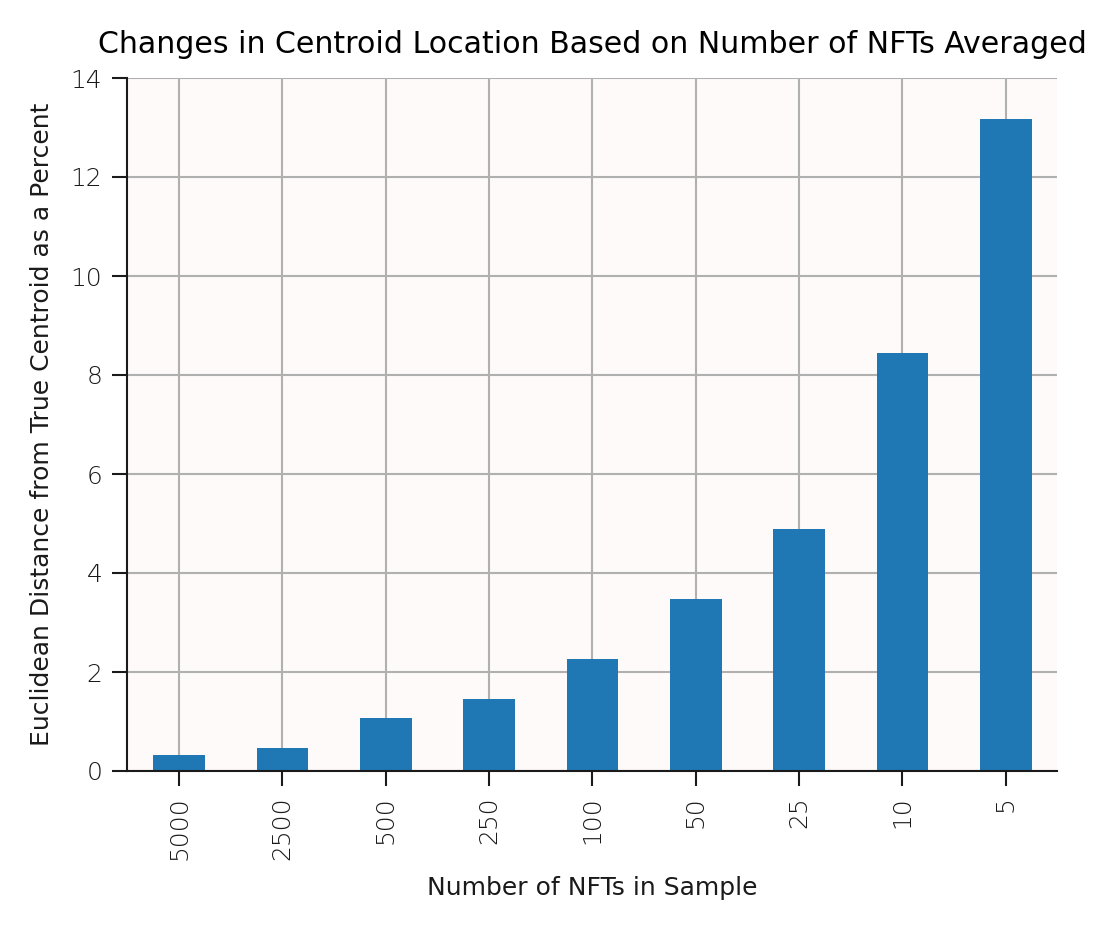

In [49]:
column_averages = [df.mean() for _,df in slug_dfs]

# Combine these averages into a new DataFrame
# Each DataFrame's column averages become a row in the new DataFrame
averages_df = pd.DataFrame(column_averages)

# Optional: If you want to name the columns to reflect their origin, you can do so like this:
# averages_df.columns = [f'Average_{i}' for i in range(len(slug_dfs))]
averages_df
df = averages_df.div(averages_df['True Dists'], axis=0)
col_avg = df.mean()
avg_df = pd.DataFrame(col_avg)
avg_df
avg_df*= 100

# Exclude the first row
avg_df = avg_df.iloc[1:]
avg_df.plot(kind='bar',legend=None)

# Adding labels and title
plt.xlabel('Number of NFTs in Sample')
plt.ylabel('Euclidean Distance from True Centroid as a Percent')
plt.title('Changes in Centroid Location Based on Number of NFTs Averaged')

# Show the plot
plt.savefig('embedding_stability.png')

In [11]:
df[f'distance_10000'] = [np.linalg.norm(afvs[0][1] - np.array(row['Features'])) for _, row in df.iterrows()]
for size,vec in afvs[1:]:
    df[f'loss_{size}'] = abs(df[f'distance_10000']-[np.linalg.norm(vec - np.array(row['Features'])) for _, row in df.iterrows()])

ValueError: too many values to unpack (expected 2)

In [46]:
df.describe()

,Label,distance_10000,loss_5000,loss_2500,loss_500,loss_250,loss_50,loss_25,loss_10,loss_5
count,10000.0,10000.000000,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,0.0,0.477893,9.172778e-04,2.233007e-03,0.003327,3.818623e-03,0.017389,1.689231e-02,0.034215,0.033327
std,0.0,0.071173,6.098213e-04,1.494059e-03,0.002304,2.575069e-03,0.011481,1.261625e-02,0.021775,0.019976
min,0.0,0.324956,2.003225e-07,8.270743e-07,0.000001,6.733999e-07,0.000006,9.724327e-07,0.000049,0.000006
25%,0.0,0.424306,3.933704e-04,1.017917e-03,0.001420,1.670476e-03,0.007795,6.482333e-03,0.016472,0.016797
50%,0.0,0.465317,8.403242e-04,2.015564e-03,0.002951,3.481500e-03,0.015880,1.419889e-02,0.031829,0.032276
75%,0.0,0.521787,1.388247e-03,3.217001e-03,0.004877,5.639650e-03,0.025887,2.523632e-02,0.049248,0.047857
max,0.0,0.786557,2.868575e-03,6.699363e-03,0.011305,1.295937e-02,0.051817,6.047855e-02,0.103424,0.097707
